# Linear Regression Starter Kit for Kaggle House Prices

This code was written by Johnston Patrick Hall <jphall@gwu.edu> and by Lisa <lisahdd007@gwmail.gwu.edu>. 
It is modified to visualize and remove a few outliers Ln [5] and add a few explanatory comments. 
But the code is otherwise left intact.

Kaggle scores the prediction blender result here at RMSE = 0.12949 (LNprices) -- 892nd on June 29, 2017.

(More recently Team ML2017Summer has improved the score to RMSE = 0.12070 (LNprices) -- 452nd on June 30, 2017.)

## Imports and inits

In [1]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.grid.grid_search import H2OGridSearch 
h2o.init(max_mem_size='12G') # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

import matplotlib as plt
import matplotlib.pyplot as pltz # This code works for plots: no '.pyplot' does not.
%matplotlib inline

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from C:\Program Files\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Kev\AppData\Local\Temp\tmp5tbvxsjx
  JVM stdout: C:\Users\Kev\AppData\Local\Temp\tmp5tbvxsjx\h2o_Kev_started_from_python.out
  JVM stderr: C:\Users\Kev\AppData\Local\Temp\tmp5tbvxsjx\h2o_Kev_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,1 month and 8 days
H2O cluster name:,H2O_from_python_Kev_m0jaik
H2O cluster total nodes:,1
H2O cluster free memory:,10.65 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


## Import data

In [2]:
train = h2o.import_file('../data/train.csv')
test = h2o.import_file('../data/test.csv')
print('training set shape:', train.shape)
print('test set shape:', test.shape)

# bug fix - from Keston - Appends a 'SalePrice' dummy column to the test set.
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print('fixed test set shape:', test.shape)

training set shape: (1460, 81)
test set shape: (1459, 80)
fixed test set shape: (1459, 81)


#### Determine data types

In [3]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [4]:
original_nums, cats = get_type_lists()

Numeric = ['EnclosedPorch', 'FullBath', 'PoolArea', 'YrSold', 'MoSold', 'Fireplaces', 'MiscVal', 'BsmtFinSF2', 'BsmtHalfBath', 'OpenPorchSF', 'BsmtFullBath', 'BsmtFinSF1', 'TotRmsAbvGrd', 'GarageArea', 'GarageCars', 'MSSubClass', 'HalfBath', 'MasVnrArea', 'YearBuilt', 'GrLivArea', '2ndFlrSF', 'OverallCond', '1stFlrSF', 'OverallQual', 'GarageYrBlt', 'LowQualFinSF', '3SsnPorch', 'TotalBsmtSF', 'KitchenAbvGr', 'BsmtUnfSF', 'LotFrontage', 'ScreenPorch', 'YearRemodAdd', 'WoodDeckSF', 'BedroomAbvGr', 'LotArea']

Categorical = ['GarageFinish', 'PavedDrive', 'BsmtQual', 'Functional', 'HouseStyle', 'Heating', 'MasVnrType', 'MSZoning', 'LandSlope', 'GarageType', 'MiscFeature', 'Condition2', 'GarageQual', 'Exterior2nd', 'BsmtFinType1', 'Utilities', 'Condition1', 'LotConfig', 'BsmtExposure', 'RoofStyle', 'BsmtCond', 'HeatingQC', 'Fence', 'KitchenQual', 'GarageCond', 'Alley', 'ExterQual', 'LandContour', 'CentralAir', 'BsmtFinType2', 'ExterCond', 'Electrical', 'BldgType', 'SaleCondition', 'SaleType'

## Identify and deal with Outliers

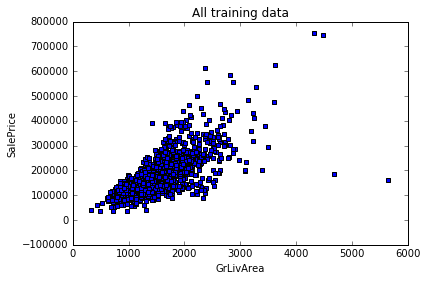

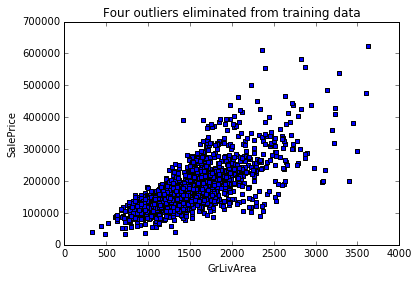

modified training data frame: (1456, 81)
modified training H2O frame: (1456, 81)


In [5]:
# The originator of the data set suggests eliminating cases with GrLivArea > 4000
#     as they are not typical and potentially influential.
# See: https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

# convert to pandas
train_df = train.as_data_frame()

pltz.scatter(train_df.GrLivArea, train_df.SalePrice, c = "blue", marker = "s")
pltz.title("All training data")
pltz.xlabel("GrLivArea")
pltz.ylabel("SalePrice")
pltz.show()

train_df = train_df[train_df.GrLivArea < 4000] # delete 4 cases with GrLivArea > 4000

pltz.scatter(train_df.GrLivArea, train_df.SalePrice, c = "blue", marker = "s")
pltz.title("Training data with four outliers eliminated")
pltz.xlabel("GrLivArea")
pltz.ylabel("SalePrice")
pltz.show()

# convert back to h2o
train = h2o.H2OFrame(train_df)
train.columns = list(train_df)
print('modified training data frame:', train_df.shape)
print('modified training H2O frame:', train.shape)

# delete pandas data frame to conserve memory 
del train_df

## Split the training data into training and validation sets

In [7]:
# Here we set aside a random 30% of the training data as a validation set. 

train, valid = train.split_frame([0.7], seed=12345)
print('Training set:', train.shape)
print('Validation set:', valid.shape)

training set: (999, 81)
vaidation set: (457, 81)


## Impute numeric missing

In [8]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = valid[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical vars using shrunken averages

http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

This encoding uses an empirical Bayesian approach to convert high-dimensional cat vars into numeric.

In [9]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


#### Execute encoding

In [10]:
total = len(cats)
for i, var in enumerate(cats):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: GarageFinish (1/43) ...
Encoding: PavedDrive (2/43) ...
Encoding: BsmtQual (3/43) ...
Encoding: Functional (4/43) ...
Encoding: HouseStyle (5/43) ...
Encoding: Heating (6/43) ...
Encoding: MasVnrType (7/43) ...
Encoding: MSZoning (8/43) ...
Encoding: LandSlope (9/43) ...
Encoding: GarageType (10/43) ...
Encoding: MiscFeature (11/43) ...
Encoding: Condition2 (12/43) ...
Encoding: GarageQual (13/43) ...
Encoding: Exterior2nd (14/43) ...
Encoding: BsmtFinType1 (15/43) ...
Encoding: Utilities (16/43) ...
Encoding: Condition1 (17/43) ...
Encoding: LotConfig (18/43) ...
Encoding: BsmtExposure (19/43) ...
Encoding: RoofStyle (20/43) ...
Encoding: BsmtCond (21/43) ...
Encoding: HeatingQC (22/43) ...
Encoding: Fence (23/43) ...
Encoding: KitchenQual (24/43) ...
Encoding: GarageCond (25/43) ...
Encoding: Alley (26/43) ...
Encoding: ExterQual (27/43) ...
Encoding: LandContour (28/43) ...
Encoding: CentralAir (29/43) ...
Encoding: BsmtFinType2 (30/43) ...
Encoding: ExterCond (31/43) ...


#### One-hot encode categorical variables

In [11]:
# one-hot encode training frame
train_cats_df = train[cats].as_data_frame()
train_cats_df_dummies = pd.get_dummies(train_cats_df)

# one-hot encode validation frame
valid_cats_df = valid[cats].as_data_frame()
valid_cats_df_dummies = pd.get_dummies(valid_cats_df)

# keep only the same new columns in the encoded new frames
# (they different b/c of different levels in variables)
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(valid_cats_df_dummies.columns))
valid_diff_cols = list(set(valid_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(valid_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in both frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# one-hot encode test frame
test_cats_df = test[cats].as_data_frame()
test_cats_df_dummies = pd.get_dummies(test_cats_df)

# keep only the same new columns in train and valid encoded frames
# (they different b/c of different levels in variables)
# remove columns in train and valid encoded frames not in encoded test frame
# remember encoded train and valid now have same columns
# so only need to check for train OR valid, not both
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(test_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in encoded train and valid frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# now remove columns in encoded test not in encoded train and valid
# (they different b/c of different levels in variables)
train_diff_cols = list(set(test_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
test_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in all encoded frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(test_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns) and all(valid_cats_df_dummies.columns == test_cats_df_dummies.columns))

# convert to h2o
train_one_hot = h2o.H2OFrame(train_cats_df_dummies.as_matrix())
train_one_hot.columns = list(train_cats_df_dummies.columns)
train = train.cbind(train_one_hot)

valid_one_hot = h2o.H2OFrame(valid_cats_df_dummies.as_matrix())
valid_one_hot.columns = list(valid_cats_df_dummies.columns)
valid = valid.cbind(valid_one_hot)

test_one_hot = h2o.H2OFrame(test_cats_df_dummies.as_matrix())
test_one_hot.columns = list(test_cats_df_dummies.columns)
test = test.cbind(test_one_hot) 

(999, 220)
(457, 220)
True
(999, 215)
(457, 215)
True
(999, 215)
(457, 215)
(1459, 215)
True


#### Redefine numerics and explore

In [12]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['SaleType_Tencode', 'LotShape_IR1', 'CentralAir_N', 'Exterior2nd_Stucco', 'OverallQual', 'Exterior1st_BrkFace', 'Fireplaces', 'MSZoning_Tencode', 'ExterCond_TA', 'SaleType_ConLw', 'Neighborhood_NAmes', 'BldgType_Duplex', 'Fence_MnWw', 'Exterior1st_Plywood', 'RoofStyle_Flat', 'GarageType_Attchd', 'Neighborhood_SawyerW', 'HouseStyle_SLvl', 'BsmtFullBath', 'BsmtFinSF1', 'TotRmsAbvGrd', 'Fence_MnPrv', 'Neighborhood_Blueste', 'HeatingQC_Tencode', 'Condition1_Artery', 'MasVnrArea', 'RoofStyle_Gable', 'YearBuilt', 'SaleType_ConLI', 'GrLivArea', 'BsmtFinType1_Tencode', 'Heating_Grav', 'Condition1_Feedr', 'Foundation_Tencode', 'Neighborhood_BrDale', 'Foundation_CBlock', 'LowQualFinSF', 'Condition2_Tencode', 'Neighborhood_NoRidge', 'Functional_Tencode', 'MSZoning_C (all)', 'Heating_Tencode', 'MiscFeature_Shed', 'FireplaceQu_Fa', 'SaleCondition_Partial', 'LotShape_Tencode', 'BsmtExposure_Tencode', 'SaleType_Oth', 'BsmtFinSF2', 'ExterQual_TA', 'BsmtFinType1_ALQ', 'MasVnrType_Stone', 'Bs

In [13]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:999
Cols:294




,SaleType_Tencode,LotShape_IR1,CentralAir_N,Exterior2nd_Stucco,OverallQual,Exterior1st_BrkFace,Fireplaces,MSZoning_Tencode,ExterCond_TA,SaleType_ConLw,Neighborhood_NAmes,BldgType_Duplex,Fence_MnWw,Exterior1st_Plywood,RoofStyle_Flat,GarageType_Attchd,Neighborhood_SawyerW,HouseStyle_SLvl,BsmtFullBath,BsmtFinSF1,TotRmsAbvGrd,Fence_MnPrv,Neighborhood_Blueste,HeatingQC_Tencode,Condition1_Artery,MasVnrArea,RoofStyle_Gable,YearBuilt,SaleType_ConLI,GrLivArea,BsmtFinType1_Tencode,Heating_Grav,Condition1_Feedr,Foundation_Tencode,Neighborhood_BrDale,Foundation_CBlock,LowQualFinSF,Condition2_Tencode,Neighborhood_NoRidge,Functional_Tencode,MSZoning_C (all),Heating_Tencode,MiscFeature_Shed,FireplaceQu_Fa,SaleCondition_Partial,LotShape_Tencode,BsmtExposure_Tencode,SaleType_Oth,BsmtFinSF2,ExterQual_TA,BsmtFinType1_ALQ,MasVnrType_Stone,BsmtExposure_Gd,ExterCond_Ex,CentralAir_Tencode,Exterior1st_VinylSd,GarageQual_Tencode,Neighborhood_Sawyer,RoofMatl_Tar&Grv,1stFlrSF,KitchenQual_Tencode,BsmtFinType1_BLQ,Exterior2nd_BrkFace,FireplaceQu_Ex,Street_Tencode,Electrical_FuseF,LotShape_IR2,Neighborhood_Mitchel,LotArea,GarageQual_TA,Electrical_FuseA,GarageFinish_Tencode,LandSlope_Tencode,SaleType_COD,PoolArea,Neighborhood_SWISU,MSZoning_FV,RoofMatl_CompShg,Neighborhood_NridgHt,LandSlope_Sev,RoofMatl_Tencode,CentralAir_Y,MSZoning_RM,SaleType_Con,MSZoning_RH,Exterior2nd_Stone,BsmtFinType2_Rec,SaleCondition_Abnorml,Neighborhood_NPkVill,FireplaceQu_Tencode,Utilities_AllPub,PavedDrive_N,HouseStyle_2.5Unf,BsmtFinType2_Tencode,SaleType_CWD,Functional_Maj1,Exterior2nd_Wd Shng,LandSlope_Gtl,LandContour_Tencode,HalfBath,Neighborhood_MeadowV,2ndFlrSF,PavedDrive_Tencode,BsmtFinType2_ALQ,GarageFinish_RFn,Functional_Min1,GarageYrBlt,BldgType_Tencode,OpenPorchSF,Foundation_Stone,Street_Pave,RoofStyle_Hip,Fence_GdPrv,Neighborhood_Blmngtn,GarageCond_TA,GarageFinish_Fin,GarageCars,KitchenQual_Ex,SaleCondition_Tencode,BldgType_2fmCon,Exterior1st_MetalSd,BsmtCond_Fa,SaleCondition_Alloca,Neighborhood_ClearCr,Foundation_Slab,LotConfig_Corner,BsmtFinType2_BLQ,KitchenAbvGr,SaleCondition_AdjLand,MiscFeature_Gar2,Exterior1st_CemntBd,RoofStyle_Shed,GarageType_BuiltIn,Condition1_Tencode,LandContour_HLS,GarageCond_Gd,Neighborhood_IDOTRR,Exterior1st_Wd Sdng,Exterior1st_WdShing,Utilities_Tencode,Neighborhood_Gilbert,MasVnrType_BrkFace,BsmtQual_Tencode,Alley_Pave,Functional_Maj2,BsmtFinType2_GLQ,Foundation_BrkTil,BsmtUnfSF,KitchenQual_TA,PoolQC_Tencode,LotShape_Reg,HouseStyle_1Story,ExterCond_Tencode,BsmtHalfBath,ExterQual_Fa,MSZoning_RL,SaleCondition_Family,Electrical_FuseP,BsmtQual_Ex,Foundation_PConc,Exterior2nd_ImStucc,GarageQual_Fa,Street_Grvl,SaleCondition_Normal,HouseStyle_Tencode,HeatingQC_Gd,LotConfig_Inside,ExterQual_Gd,PoolQC_Gd,Neighborhood_Tencode,Condition1_PosN,MSSubClass,Heating_GasA,GarageQual_Gd,GarageType_Detchd,ExterCond_Gd,BsmtCond_Po,BsmtFinType1_GLQ,Condition2_Artery,BsmtExposure_Mn,ExterQual_Tencode,LandContour_Bnk,3SsnPorch,TotalBsmtSF,Exterior2nd_CmentBd,KitchenQual_Gd,Exterior2nd_Plywood,HouseStyle_2Story,FireplaceQu_Po,ExterQual_Ex,Neighborhood_Crawfor,Heating_Wall,Neighborhood_Somerst,SaleType_New,HeatingQC_Ex,MasVnrType_Tencode,Condition2_Norm,HouseStyle_1.5Unf,BsmtExposure_No,HeatingQC_TA,BsmtFinType2_LwQ,Neighborhood_BrkSide,RoofMatl_WdShngl,HouseStyle_1.5Fin,Condition1_Norm,FireplaceQu_Gd,LandSlope_Mod,BedroomAbvGr,Exterior1st_Stucco,EnclosedPorch,KitchenQual_Fa,GarageType_2Types,RoofStyle_Gambrel,Condition1_RRAn,LotShape_IR3,Neighborhood_NWAmes,BsmtFinType1_Unf,FullBath,GarageQual_Po,PavedDrive_Y,Exterior2nd_AsbShng,Exterior2nd_MetalSd,YrSold,GarageType_CarPort,Neighborhood_Edwards,Exterior1st_AsbShng,Neighborhood_CollgCr,Exterior2nd_HdBoard,GarageCond_Tencode,LotConfig_Tencode,BldgType_Twnhs,GarageType_Basment,SaleType_ConLD,ExterCond_Fa,BsmtCond_TA,Exterior1st_Tencode,HouseStyle_SFoyer,WoodDeckSF,Neighborhood_Timber,BsmtExposure_Av,Neighborhood_StoneBr,Electrical_SBrkr,BsmtFinType1_Rec,GarageCond_Po,MasVnrType_BrkCmn,Alley_Tencode,BsmtQual_Fa,Garage

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:457
Cols:294




,SaleType_Tencode,LotShape_IR1,CentralAir_N,Exterior2nd_Stucco,OverallQual,Exterior1st_BrkFace,Fireplaces,MSZoning_Tencode,ExterCond_TA,SaleType_ConLw,Neighborhood_NAmes,BldgType_Duplex,Fence_MnWw,Exterior1st_Plywood,RoofStyle_Flat,GarageType_Attchd,Neighborhood_SawyerW,HouseStyle_SLvl,BsmtFullBath,BsmtFinSF1,TotRmsAbvGrd,Fence_MnPrv,Neighborhood_Blueste,HeatingQC_Tencode,Condition1_Artery,MasVnrArea,RoofStyle_Gable,YearBuilt,SaleType_ConLI,GrLivArea,BsmtFinType1_Tencode,Heating_Grav,Condition1_Feedr,Foundation_Tencode,Neighborhood_BrDale,Foundation_CBlock,LowQualFinSF,Condition2_Tencode,Neighborhood_NoRidge,Functional_Tencode,MSZoning_C (all),Heating_Tencode,MiscFeature_Shed,FireplaceQu_Fa,SaleCondition_Partial,LotShape_Tencode,BsmtExposure_Tencode,SaleType_Oth,BsmtFinSF2,ExterQual_TA,BsmtFinType1_ALQ,MasVnrType_Stone,BsmtExposure_Gd,ExterCond_Ex,CentralAir_Tencode,Exterior1st_VinylSd,GarageQual_Tencode,Neighborhood_Sawyer,RoofMatl_Tar&Grv,1stFlrSF,KitchenQual_Tencode,BsmtFinType1_BLQ,Exterior2nd_BrkFace,FireplaceQu_Ex,Street_Tencode,Electrical_FuseF,LotShape_IR2,Neighborhood_Mitchel,LotArea,GarageQual_TA,Electrical_FuseA,GarageFinish_Tencode,LandSlope_Tencode,SaleType_COD,PoolArea,Neighborhood_SWISU,MSZoning_FV,RoofMatl_CompShg,Neighborhood_NridgHt,LandSlope_Sev,RoofMatl_Tencode,CentralAir_Y,MSZoning_RM,SaleType_Con,MSZoning_RH,Exterior2nd_Stone,BsmtFinType2_Rec,SaleCondition_Abnorml,Neighborhood_NPkVill,FireplaceQu_Tencode,Utilities_AllPub,PavedDrive_N,HouseStyle_2.5Unf,BsmtFinType2_Tencode,SaleType_CWD,Functional_Maj1,Exterior2nd_Wd Shng,LandSlope_Gtl,LandContour_Tencode,HalfBath,Neighborhood_MeadowV,2ndFlrSF,PavedDrive_Tencode,BsmtFinType2_ALQ,GarageFinish_RFn,Functional_Min1,GarageYrBlt,BldgType_Tencode,OpenPorchSF,Foundation_Stone,Street_Pave,RoofStyle_Hip,Fence_GdPrv,Neighborhood_Blmngtn,GarageCond_TA,GarageFinish_Fin,GarageCars,KitchenQual_Ex,SaleCondition_Tencode,BldgType_2fmCon,Exterior1st_MetalSd,BsmtCond_Fa,SaleCondition_Alloca,Neighborhood_ClearCr,Foundation_Slab,LotConfig_Corner,BsmtFinType2_BLQ,KitchenAbvGr,SaleCondition_AdjLand,MiscFeature_Gar2,Exterior1st_CemntBd,RoofStyle_Shed,GarageType_BuiltIn,Condition1_Tencode,LandContour_HLS,GarageCond_Gd,Neighborhood_IDOTRR,Exterior1st_Wd Sdng,Exterior1st_WdShing,Utilities_Tencode,Neighborhood_Gilbert,MasVnrType_BrkFace,BsmtQual_Tencode,Alley_Pave,Functional_Maj2,BsmtFinType2_GLQ,Foundation_BrkTil,BsmtUnfSF,KitchenQual_TA,PoolQC_Tencode,LotShape_Reg,HouseStyle_1Story,ExterCond_Tencode,BsmtHalfBath,ExterQual_Fa,MSZoning_RL,SaleCondition_Family,Electrical_FuseP,BsmtQual_Ex,Foundation_PConc,Exterior2nd_ImStucc,GarageQual_Fa,Street_Grvl,SaleCondition_Normal,HouseStyle_Tencode,HeatingQC_Gd,LotConfig_Inside,ExterQual_Gd,PoolQC_Gd,Neighborhood_Tencode,Condition1_PosN,MSSubClass,Heating_GasA,GarageQual_Gd,GarageType_Detchd,ExterCond_Gd,BsmtCond_Po,BsmtFinType1_GLQ,Condition2_Artery,BsmtExposure_Mn,ExterQual_Tencode,LandContour_Bnk,3SsnPorch,TotalBsmtSF,Exterior2nd_CmentBd,KitchenQual_Gd,Exterior2nd_Plywood,HouseStyle_2Story,FireplaceQu_Po,ExterQual_Ex,Neighborhood_Crawfor,Heating_Wall,Neighborhood_Somerst,SaleType_New,HeatingQC_Ex,MasVnrType_Tencode,Condition2_Norm,HouseStyle_1.5Unf,BsmtExposure_No,HeatingQC_TA,BsmtFinType2_LwQ,Neighborhood_BrkSide,RoofMatl_WdShngl,HouseStyle_1.5Fin,Condition1_Norm,FireplaceQu_Gd,LandSlope_Mod,BedroomAbvGr,Exterior1st_Stucco,EnclosedPorch,KitchenQual_Fa,GarageType_2Types,RoofStyle_Gambrel,Condition1_RRAn,LotShape_IR3,Neighborhood_NWAmes,BsmtFinType1_Unf,FullBath,GarageQual_Po,PavedDrive_Y,Exterior2nd_AsbShng,Exterior2nd_MetalSd,YrSold,GarageType_CarPort,Neighborhood_Edwards,Exterior1st_AsbShng,Neighborhood_CollgCr,Exterior2nd_HdBoard,GarageCond_Tencode,LotConfig_Tencode,BldgType_Twnhs,GarageType_Basment,SaleType_ConLD,ExterCond_Fa,BsmtCond_TA,Exterior1st_Tencode,HouseStyle_SFoyer,WoodDeckSF,Neighborhood_Timber,BsmtExposure_Av,Neighborhood_StoneBr,Electrical_SBrkr,BsmtFinType1_Rec,GarageCond_Po,MasVnrType_BrkCmn,Alley_Tencode,BsmtQual_Fa,Garage

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:294




,SaleType_Tencode,LotShape_IR1,CentralAir_N,Exterior2nd_Stucco,OverallQual,Exterior1st_BrkFace,Fireplaces,MSZoning_Tencode,ExterCond_TA,SaleType_ConLw,Neighborhood_NAmes,BldgType_Duplex,Fence_MnWw,Exterior1st_Plywood,RoofStyle_Flat,GarageType_Attchd,Neighborhood_SawyerW,HouseStyle_SLvl,BsmtFullBath,BsmtFinSF1,TotRmsAbvGrd,Fence_MnPrv,Neighborhood_Blueste,HeatingQC_Tencode,Condition1_Artery,MasVnrArea,RoofStyle_Gable,YearBuilt,SaleType_ConLI,GrLivArea,BsmtFinType1_Tencode,Heating_Grav,Condition1_Feedr,Foundation_Tencode,Neighborhood_BrDale,Foundation_CBlock,LowQualFinSF,Condition2_Tencode,Neighborhood_NoRidge,Functional_Tencode,MSZoning_C (all),Heating_Tencode,MiscFeature_Shed,FireplaceQu_Fa,SaleCondition_Partial,LotShape_Tencode,BsmtExposure_Tencode,SaleType_Oth,BsmtFinSF2,ExterQual_TA,BsmtFinType1_ALQ,MasVnrType_Stone,BsmtExposure_Gd,ExterCond_Ex,CentralAir_Tencode,Exterior1st_VinylSd,GarageQual_Tencode,Neighborhood_Sawyer,RoofMatl_Tar&Grv,1stFlrSF,KitchenQual_Tencode,BsmtFinType1_BLQ,Exterior2nd_BrkFace,FireplaceQu_Ex,Street_Tencode,Electrical_FuseF,LotShape_IR2,Neighborhood_Mitchel,LotArea,GarageQual_TA,Electrical_FuseA,GarageFinish_Tencode,LandSlope_Tencode,SaleType_COD,PoolArea,Neighborhood_SWISU,MSZoning_FV,RoofMatl_CompShg,Neighborhood_NridgHt,LandSlope_Sev,RoofMatl_Tencode,CentralAir_Y,MSZoning_RM,SaleType_Con,MSZoning_RH,Exterior2nd_Stone,BsmtFinType2_Rec,SaleCondition_Abnorml,Neighborhood_NPkVill,FireplaceQu_Tencode,Utilities_AllPub,PavedDrive_N,HouseStyle_2.5Unf,BsmtFinType2_Tencode,SaleType_CWD,Functional_Maj1,Exterior2nd_Wd Shng,LandSlope_Gtl,LandContour_Tencode,HalfBath,Neighborhood_MeadowV,2ndFlrSF,PavedDrive_Tencode,BsmtFinType2_ALQ,GarageFinish_RFn,Functional_Min1,GarageYrBlt,BldgType_Tencode,OpenPorchSF,Foundation_Stone,Street_Pave,RoofStyle_Hip,Fence_GdPrv,Neighborhood_Blmngtn,GarageCond_TA,GarageFinish_Fin,GarageCars,KitchenQual_Ex,SaleCondition_Tencode,BldgType_2fmCon,Exterior1st_MetalSd,BsmtCond_Fa,SaleCondition_Alloca,Neighborhood_ClearCr,Foundation_Slab,LotConfig_Corner,BsmtFinType2_BLQ,KitchenAbvGr,SaleCondition_AdjLand,MiscFeature_Gar2,Exterior1st_CemntBd,RoofStyle_Shed,GarageType_BuiltIn,Condition1_Tencode,LandContour_HLS,GarageCond_Gd,Neighborhood_IDOTRR,Exterior1st_Wd Sdng,Exterior1st_WdShing,Utilities_Tencode,Neighborhood_Gilbert,MasVnrType_BrkFace,BsmtQual_Tencode,Alley_Pave,Functional_Maj2,BsmtFinType2_GLQ,Foundation_BrkTil,BsmtUnfSF,KitchenQual_TA,PoolQC_Tencode,LotShape_Reg,HouseStyle_1Story,ExterCond_Tencode,BsmtHalfBath,ExterQual_Fa,MSZoning_RL,SaleCondition_Family,Electrical_FuseP,BsmtQual_Ex,Foundation_PConc,Exterior2nd_ImStucc,GarageQual_Fa,Street_Grvl,SaleCondition_Normal,HouseStyle_Tencode,HeatingQC_Gd,LotConfig_Inside,ExterQual_Gd,PoolQC_Gd,Neighborhood_Tencode,Condition1_PosN,MSSubClass,Heating_GasA,GarageQual_Gd,GarageType_Detchd,ExterCond_Gd,BsmtCond_Po,BsmtFinType1_GLQ,Condition2_Artery,BsmtExposure_Mn,ExterQual_Tencode,LandContour_Bnk,3SsnPorch,TotalBsmtSF,Exterior2nd_CmentBd,KitchenQual_Gd,Exterior2nd_Plywood,HouseStyle_2Story,FireplaceQu_Po,ExterQual_Ex,Neighborhood_Crawfor,Heating_Wall,Neighborhood_Somerst,SaleType_New,HeatingQC_Ex,MasVnrType_Tencode,Condition2_Norm,HouseStyle_1.5Unf,BsmtExposure_No,HeatingQC_TA,BsmtFinType2_LwQ,Neighborhood_BrkSide,RoofMatl_WdShngl,HouseStyle_1.5Fin,Condition1_Norm,FireplaceQu_Gd,LandSlope_Mod,BedroomAbvGr,Exterior1st_Stucco,EnclosedPorch,KitchenQual_Fa,GarageType_2Types,RoofStyle_Gambrel,Condition1_RRAn,LotShape_IR3,Neighborhood_NWAmes,BsmtFinType1_Unf,FullBath,GarageQual_Po,PavedDrive_Y,Exterior2nd_AsbShng,Exterior2nd_MetalSd,YrSold,GarageType_CarPort,Neighborhood_Edwards,Exterior1st_AsbShng,Neighborhood_CollgCr,Exterior2nd_HdBoard,GarageCond_Tencode,LotConfig_Tencode,BldgType_Twnhs,GarageType_Basment,SaleType_ConLD,ExterCond_Fa,BsmtCond_TA,Exterior1st_Tencode,HouseStyle_SFoyer,WoodDeckSF,Neighborhood_Timber,BsmtExposure_Av,Neighborhood_StoneBr,Electrical_SBrkr,BsmtFinType1_Rec,GarageCond_Po,MasVnrType_BrkCmn,Alley_Tencode,BsmtQual_Fa,Garage

In [15]:
# Check Neighborhood_Tencode

print(test[0:6, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   152080
# NAmes   152080
# Gilbert 191808
# Gilbert 191808
# StoneBr 288359

Neighborhood,Neighborhood_Tencode
NAmes,147939
NAmes,147939
Gilbert,201403
Gilbert,201403
StoneBr,287145
Gilbert,201403



{'CollgCr': 199112.73534372722, 'OldTown': 132190.99576039388, 'BrkSide': 129347.50056808617, 'Blueste': 155717.93326039388, nan: 182452.88840262583, 'Mitchel': 168708.76659372722, 'NAmes': 147938.5379901236, 'StoneBr': 287145.0277048383, 'BrDale': 119061.68326039388, 'Crawfor': 209330.0486450093, 'NridgHt': 294812.10326039384, 'Veenker': 231261.68326039388, 'IDOTRR': 112187.81053312114, 'Somerst': 219382.8678757785, 'ClearCr': 219184.59992706054, 'NWAmes': 185174.90694460442, 'SWISU': 159962.62076039388, 'Edwards': 128170.20598766659, 'NoRidge': 319016.0101834708, 'Timber': 227565.34235130297, 'Sawyer': 145686.29864500926, 'MeadowV': 132215.43326039388, 'Blmngtn': 169402.93326039388, 'SawyerW': 179608.24576039388, 'NPkVill': 155009.59992706054, 'Gilbert': 201402.67076039387}


## Create combination features

This section creates all possible two-way interaction terms from the numeric features.
This dramatically expands the set of possible regressors so that the significance of 
all possible interactions may be tested in the model building phase.

In [16]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features 
                            and onto which generated features will be cbound.
    :param test_frame: Test frame from which to generate features and onto which
                            generated features will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [17]:
train, _ = feature_combiner(train, test, encoded_nums)
valid, test = feature_combiner(valid, test, encoded_nums)

Combining: SaleType_Tencode (1/294) ...
Combining: LotShape_IR1 (2/294) ...
Combining: CentralAir_N (3/294) ...
Combining: Exterior2nd_Stucco (4/294) ...
Combining: OverallQual (5/294) ...
Combining: Exterior1st_BrkFace (6/294) ...
Combining: Fireplaces (7/294) ...
Combining: MSZoning_Tencode (8/294) ...
Combining: ExterCond_TA (9/294) ...
Combining: SaleType_ConLw (10/294) ...
Combining: Neighborhood_NAmes (11/294) ...
Combining: BldgType_Duplex (12/294) ...
Combining: Fence_MnWw (13/294) ...
Combining: Exterior1st_Plywood (14/294) ...
Combining: RoofStyle_Flat (15/294) ...
Combining: GarageType_Attchd (16/294) ...
Combining: Neighborhood_SawyerW (17/294) ...
Combining: HouseStyle_SLvl (18/294) ...
Combining: BsmtFullBath (19/294) ...
Combining: BsmtFinSF1 (20/294) ...
Combining: TotRmsAbvGrd (21/294) ...
Combining: Fence_MnPrv (22/294) ...
Combining: Neighborhood_Blueste (23/294) ...
Combining: HeatingQC_Tencode (24/294) ...
Combining: Condition1_Artery (25/294) ...
Combining: MasVnr

#### Redefine numerics and explore

In [18]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['LandSlope_Sev|Neighborhood_Blmngtn', 'Electrical_FuseF|Exterior2nd_CmentBd', 'ExterQual_Gd|MSSubClass', 'SaleCondition_Family|BsmtCond_Gd', 'Exterior2nd_Wd Shng|Fence_GdWo', 'BsmtFinSF1|LotConfig_Corner', 'Foundation_PConc|RoofStyle_Gambrel', 'Utilities_AllPub|LotConfig_Tencode', 'BsmtExposure_Gd|BsmtQual_TA', 'HouseStyle_SLvl|FullBath', 'RoofMatl_CompShg|SaleCondition_Abnorml', 'Exterior2nd_Plywood|Neighborhood_Edwards', 'LandContour_Lvl|BldgType_TwnhsE', 'HeatingQC_Tencode|Exterior1st_CemntBd', 'GarageType_CarPort|GarageCond_Tencode', 'MSZoning_C (all)|BsmtFinType1_GLQ', 'Fence_MnWw|SaleCondition_Normal', 'Heating_Wall|YearRemodAdd', 'Condition1_Feedr|FireplaceQu_Fa', 'CentralAir_Tencode|LotShape_IR3', 'RoofStyle_Hip|Neighborhood_Tencode', 'KitchenQual_TA|Condition1_PosN', 'BsmtFinType1_Unf|Exterior2nd_AsbShng', 'HouseStyle_SLvl|RoofMatl_WdShngl', 'GarageCars|HouseStyle_2Story', 'LotConfig_Corner|BsmtExposure_Av', 'SaleType_ConLD|Functional_Min2', 'Neighborhood_BrDale|Nei

In [19]:
# check number of created variables is correct
# 1 id column, 290)) combined variables
print(train.shape == (999, sum(range(1, 290), (290 + 43 + 1 + 1))))
print(train.shape)
print(test.shape == (1459, sum(range(1, 290), (290 + 43 + 1 + 1))))
print(test.shape)

False
(999, 43410)
False
(1459, 43410)


In [20]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

BsmtExposure_Av,BsmtQual_Fa,BsmtExposure_Av|BsmtQual_Fa
0,0,0


BsmtExposure_Av,BsmtQual_Fa,BsmtExposure_Av|BsmtQual_Fa
0,0,0



0.0
0.0


## Train models

In [21]:
h2o.show_progress()                                          # turn on progress bars

SalePrice
12.2477
12.109
12.3172


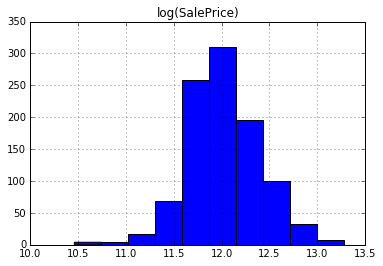

In [22]:
# Check log transform - looks good
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Split training data

In [25]:
half_train, other_half_train = train.split_frame([0.5], seed=12345)
half_valid, other_half_valid = valid.split_frame([0.5], seed=12345)
print('1st half train shape:', half_train.shape)
print('1st half valid shape:', half_valid.shape)
print('other half train shape:', other_half_train.shape)
print('other_half_valid.shape:', other_half_valid.shape)
# no idea why this works better, but it does ... 
# could be a lucky split that happens to be more representative of test data
# could be that it just prevents overfitting

1st half train shape: (503, 43410)
1st half valid shape: (228, 43410)
other half train shape: (496, 43410)
other_half_valid.shape: (229, 43410)


#### Define model with grid search function

In [26]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best


#### Function to generate submission file

In [27]:
import re
import time

def gen_submission(model, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param model: Model with which to score test data.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(model.predict(test).exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)


#### Simple function to average predictions

In [28]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)
     

#### GLM model on encoded, embedded, combined numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_314_sid_8772_model_python_1498762871614_1_model_0   
1     [0.5]  Grid_GLM_py_314_sid_8772_model_python_1498762871614_1_model_2   
2    [0.25]  Grid_GLM_py_314_sid_8772_model_python_1498762871614_1_model_1   
3    [0.99]  Grid_GLM_py_314_sid_8772_model_python_1498762871614_1_model_3   

    residual_deviance  
0  3.7046452611133676  
1   3.749163211991294  
2   3.772453257707003  
3  4.0632132126300355  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_314_sid_8772_model_python_1498762871614_1_model_0


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.003377826641930848
RMSE: 0.05811907296172959
MAE: 0.04696715593311222
RMSLE: 0.004510285449146765
R^2: 0.977415414878491
Mean Residual Deviance: 0.003377826641930848
Null degrees of f

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-29 17:52:09,0.000 sec,0,.3E2,32,0.1473876,0.1761545
,2017-06-29 17:52:12,2.691 sec,0,.29E2,50,0.1422443,0.1699129
,2017-06-29 17:52:30,20.265 sec,0,.28E2,60,0.1364260,0.1627895
,2017-06-29 17:52:31,21.653 sec,0,.26E2,91,0.1299326,0.1547543
,2017-06-29 17:52:32,22.845 sec,0,.25E2,120,0.1230663,0.1462123
---,---,---,---,---,---,---,---
,2017-06-29 17:56:08,3 min 58.740 sec,0,.38E0,1473,0.0025171,0.0163277
,2017-06-29 17:56:13,4 min 3.604 sec,0,.37E0,1490,0.0023678,0.0163502
,2017-06-29 17:56:17,4 min 7.813 sec,0,.35E0,1505,0.0022255,0.0163790
,2017-06-29 17:56:20,4 min 10.948 sec,0,.33E0,1517,0.0020937,0.0164036



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.1453
12.2061,12.2385
11.6784,11.76
11.914,11.875
12.6758,12.5915
12.861,12.9086
12.1035,12.0148
11.2898,11.4883
11.7714,11.7176
11.5843,11.6475



glm prediction progress: |████████████████████████████████████████████████| 100%


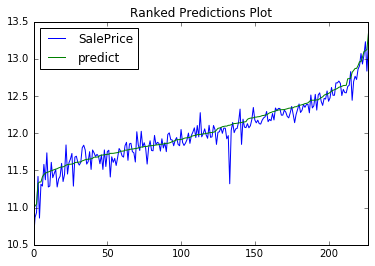

In [29]:
glm_0 = glm_grid(encoded_combined_nums, 'SalePrice', half_train, half_valid)
gen_submission(glm_0) # Valid RMSE: ~0.1275,  Not submitted to Kaggle

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_316_sid_8772_model_python_1498762871614_2_model_1   
1     [0.5]  Grid_GLM_py_316_sid_8772_model_python_1498762871614_2_model_2   
2    [0.99]  Grid_GLM_py_316_sid_8772_model_python_1498762871614_2_model_3   
3    [0.01]  Grid_GLM_py_316_sid_8772_model_python_1498762871614_2_model_0   

    residual_deviance  
0  3.2063645373359337  
1   3.209294447893575  
2    3.29789381542734  
3  3.3560418239476473  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_316_sid_8772_model_python_1498762871614_2_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.005923738226965132
RMSE: 0.07696582505869168
MAE: 0.057503099179196195
RMSLE: 0.005918545464200997
R^2: 0.95875182150063
Mean Residual Deviance: 0.005923738226965132
Null degrees of f

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-29 18:13:26,0.000 sec,0,.12E1,8,0.1365043,0.1688921
,2017-06-29 18:13:28,2.045 sec,0,.12E1,13,0.1279523,0.1570314
,2017-06-29 18:13:29,3.236 sec,0,.11E1,16,0.1196071,0.1454079
,2017-06-29 18:13:30,4.494 sec,0,.11E1,23,0.1117605,0.1345490
,2017-06-29 18:13:43,17.930 sec,0,.1E1,26,0.1043994,0.1244938
---,---,---,---,---,---,---,---
,2017-06-29 18:16:11,2 min 45.242 sec,0,.15E-1,385,0.0024117,0.0148502
,2017-06-29 18:16:14,2 min 48.025 sec,0,.15E-1,390,0.0022817,0.0149280
,2017-06-29 18:16:15,2 min 49.949 sec,0,.14E-1,398,0.0021556,0.0149978
,2017-06-29 18:16:17,2 min 51.547 sec,0,.13E-1,415,0.0020341,0.0150405



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.7906,11.7421
11.9117,11.9748
11.9767,11.9189
11.8451,11.743
11.1346,11.3598
11.8845,11.8899
11.9382,11.9648
11.8565,11.7989
11.9704,11.9995
12.6667,12.7171



glm prediction progress: |████████████████████████████████████████████████| 100%


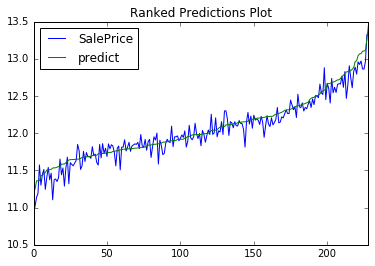

In [30]:
glm_1 = glm_grid(encoded_combined_nums, 'SalePrice', other_half_train, other_half_valid)
gen_submission(glm_1) # Valid RMSE: ~0.1183, Not submitted to Kaggle

#### Blend predictions

In [31]:
pred_blender('../data/', 
             ['submission_Thu_Jun_29_18_07_14_2017.csv',
              'submission_Thu_Jun_29_18_23_40_2017.csv'])
# 0.12949 on public leaderboard -- from past submission experience this is MUCH better than either single model!

     Id     SalePrice0     SalePrice1           mean
0  1461  124845.230685  114234.100956  119539.665821
1  1462  165041.827379  154313.882690  159677.855035
2  1463  192134.747084  175959.756830  184047.251957
3  1464  204591.610397  198965.475062  201778.542730
4  1465  200407.275450  199303.544389  199855.409920


In [32]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? Y
